In [1]:
%pip install -U pandas

Requirement already up-to-date: pandas in /opt/conda/lib/python3.7/site-packages (0.25.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urlencode
import pickle
from pathlib import Path

In [3]:
pd.options.display.max_rows = 10

# Base EU6D data

In [6]:
# path to the data
src = Path("./data/euro-6d-temp-modelle.pickle")

# Create dir if it does not exists
if not src.parent.exists(): 
    src.parent.mkdir()

# Try to update the data
try:
    res = pd.read_html("https://www.adac.de/rund-ums-fahrzeug/auto-kaufen-verkaufen/neuwagenkauf/euro-6d-temp-modelle", header=0)
except:
    with open(src, "rb") as _output:
        res = pickle.load(_output)
else:
    with open(src, "wb") as _input:
        pickle.dump(res, _input)

*res* is a list of Dataframes

In [7]:
res[0].head(1)

,Hersteller,Modell,Motorart,Hubraum in ccm,Leistung in KW,Abgasnorm,Markt- einführung
0,Abarth,595,Otto,1368,107,Euro 6d-TEMP-EVAP,Sep. 18


In [4]:
res[1].head(1)

,Hersteller,Modell,Motorart,Hubraum in ccm,Leistung in KW,Abgasnorm,Markt- einführung
0,Alfa Romeo,Giulia 2.0 Turbo 16V,Otto,1955,147,Euro 6d-TEMP,Sep. 18


Concatenate all tables and reindex 

In [8]:
df = pd.concat((elt for elt in res), ignore_index=True)
df.rename({
    'Markt-  einführung': 'Markteinfuehrung',
    'Hubraum in ccm': 'Hubraum',
    'Leistung in KW': 'Leistung'
    }, axis=1, inplace=True)

In [9]:
df.head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
0,Abarth,595,Otto,1368,107,Euro 6d-TEMP-EVAP,Sep. 18
1,Abarth,595 Pista,Otto,1368,118,Euro 6d-TEMP-EVAP,Sep. 18
2,Abarth,595 Turismo,Otto,1368,121,Euro 6d-TEMP-EVAP,Sep. 18
3,Abarth,595 Competizione,Otto,1368,132,Euro 6d-TEMP-EVAP,Sep. 18
4,Abarth,595C,Otto,1368,107,Euro 6d-TEMP-EVAP,Sep. 18


In [10]:
df.describe().astype(int)

,Hubraum,Leistung
count,2874,2874
mean,2062,157
std,878,92
min,195,44
25%,1499,95
50%,1969,132
75%,1998,190
max,6749,566


In [11]:
df.Abgasnorm.unique()

array(['Euro 6d-TEMP-EVAP', 'Euro 6d-TEMP', 'Euro 6d-TEMP-EVAP-ISC',
       'Euro 6d-ISC', 'Euro 6d', 'Euro 6d-ISC-FCM', 'Euro 6d-TEMP-ISC'],
      dtype=object)

# Data types, memory, column manipulation

In [84]:
df.dtypes

Hersteller                category
Modell                      object
Motorart                    object
Hubraum                      int64
Leistung                     int64
Abgasnorm                 category
Markteinfuehrung    datetime64[ns]
Literleistung                int64
dtype: object

In [9]:
df.memory_usage()

Index                 128
Hersteller          22992
Modell              22992
Motorart            22992
Hubraum             22992
Leistung            22992
Abgasnorm           22992
Markteinfuehrung    22992
dtype: int64

Convert *Markteinfuehrung* col to datetime

For date manipulation, see for ex.https://www.python-kurs.eu/python3_time_and_date.php

In [10]:
import locale

locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

pat = r"^(\w{3}).*(\d{2})$"
repl = lambda m: f"{m.group(1)} {m.group(2)}"

df.Markteinfuehrung = df.Markteinfuehrung \
    .str.replace('^v', 'Nov') \
    .str.replace('(Mrz|Mar)', 'Mär') \
    .str.replace(pat, repl)

df.Markteinfuehrung = pd.to_datetime(df.Markteinfuehrung, format='%b %y', errors='coerce')

In [11]:
df = df.astype({
    'Hersteller': 'category',
    'Abgasnorm': 'category'
    })

In [12]:
df.dtypes

Hersteller                category
Modell                      object
Motorart                    object
Hubraum                      int64
Leistung                     int64
Abgasnorm                 category
Markteinfuehrung    datetime64[ns]
dtype: object

In [13]:
df.sample(5)

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
1866,Opel,ADAM 1.4 LPG ECOTEC,Autogas,1398,64,Euro 6d-TEMP,2018-04-01
853,Ford,Focus Turnier 2.0 EcoBlue,Diesel,1995,110,Euro 6d-TEMP,2018-09-01
1580,Mercedes,E 200 Coupé,Otto,1991,155,Euro 6d-TEMP-EVAP-ISC,2019-06-01
1818,MINI,Clubman Cooper SD,Diesel,1995,140,Euro 6d-TEMP-EVAP,2018-03-01
2664,VW,Caddy Kombi 2.0 TDI SCR,Diesel,1968,90,Euro 6d-TEMP-EVAP-ISC,2019-07-01


In [14]:
df.describe()

,Hubraum,Leistung
count,2874.000000,2874.000000
mean,2062.925191,157.884134
std,878.655431,92.194313
min,195.000000,44.000000
25%,1499.000000,95.000000
50%,1969.000000,132.000000
75%,1998.000000,190.000000
max,6749.000000,566.000000


# Selection

In [15]:
df['Hersteller']

0       Abarth
1       Abarth
2       Abarth
3       Abarth
4       Abarth
         ...  
2869        VW
2870        VW
2871        VW
2872        VW
2873        VW
Name: Hersteller, Length: 2874, dtype: category
Categories (44, object): [ALPINA, Abarth, Alfa Romeo, Alpine, ..., Suzuki, Toyota, VW, Volvo]

In [16]:
df.Hersteller

0       Abarth
1       Abarth
2       Abarth
3       Abarth
4       Abarth
         ...  
2869        VW
2870        VW
2871        VW
2872        VW
2873        VW
Name: Hersteller, Length: 2874, dtype: category
Categories (44, object): [ALPINA, Abarth, Alfa Romeo, Alpine, ..., Suzuki, Toyota, VW, Volvo]

In [17]:
df.Hersteller.unique()

[Abarth, Alfa Romeo, ALPINA, Alpine, Audi, ..., Subaru, Suzuki, Toyota, Volvo, VW]
Length: 44
Categories (44, object): [Abarth, Alfa Romeo, ALPINA, Alpine, ..., Suzuki, Toyota, Volvo, VW]

In [18]:
df[['Hersteller', 'Hubraum']].sample(3)

,Hersteller,Hubraum
821,Ford,998
1454,Mercedes,1598
712,Dacia,1332


## Masks

In [19]:
mask = df.Hubraum > 3000
mask

0       False
1       False
2       False
3       False
4       False
        ...  
2869    False
2870    False
2871    False
2872    False
2873    False
Name: Hubraum, Length: 2874, dtype: bool

In [75]:
df[mask]

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
266,Audi,R8 Coupé 5.2 FSI V10,Otto,5204,419,Euro 6d-TEMP,2019-02-01,80
267,Audi,R8 Coupé 5.2 FSI V10,Otto,5204,419,Euro 6d-TEMP-EVAP-ISC,2019-05-01,80
268,Audi,R8 Coupé 5.2 FSI V10 Decennium,Otto,5204,456,Euro 6d-TEMP,2019-02-01,87
269,Audi,R8 Coupé 5.2 FSI V10 performance,Otto,5204,456,Euro 6d-TEMP,2019-02-01,87
270,Audi,R8 Coupé 5.2 FSI V10 performance,Otto,5204,456,Euro 6d-TEMP-EVAP-ISC,2019-05-01,87


In [22]:
dHersteller = ["Audi", "BMW", "Mercedes", "Porsche", "VW"]

In [34]:
mask = (df.Leistung > 400) & (df.Hubraum > 4000) & df.Hersteller.isin(dHersteller)

In [74]:
df[mask].sort_values(by='Leistung', ascending=False).head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
1733,Mercedes,Maybach S 650,Otto,5980,463,Euro 6d-TEMP,2018-06-01,77
1762,Mercedes,S 65 AMG Coupé,Otto,5980,463,Euro 6d-TEMP,2018-08-01,77
1761,Mercedes,S 65 AMG Cabriolet,Otto,5980,463,Euro 6d-TEMP,2018-08-01,77
1759,Mercedes,S 65 AMG,Otto,5980,463,Euro 6d-TEMP,2018-06-01,77
1734,Mercedes,Maybach S 650,Otto,5980,463,Euro 6d-TEMP-EVAP-ISC,2019-06-01,77


## `.iloc`, `.loc`

C-order!

In [41]:
df.iloc[1]

Hersteller                       Abarth
Modell                        595 Pista
Motorart                           Otto
Hubraum                            1368
Leistung                            118
Abgasnorm             Euro 6d-TEMP-EVAP
Markteinfuehrung    2018-09-01 00:00:00
Name: 1, dtype: object

In [42]:
df.iloc[:, 0]

0       Abarth
1       Abarth
2       Abarth
3       Abarth
4       Abarth
         ...  
2869        VW
2870        VW
2871        VW
2872        VW
2873        VW
Name: Hersteller, Length: 2874, dtype: category
Categories (44, object): [ALPINA, Abarth, Alfa Romeo, Alpine, ..., Suzuki, Toyota, VW, Volvo]

In [43]:
df.loc[2869]

Hersteller                           VW
Modell               Touran 2.0 TDI SCR
Motorart                         Diesel
Hubraum                            1968
Leistung                            140
Abgasnorm                  Euro 6d-TEMP
Markteinfuehrung    2019-01-01 00:00:00
Name: 2869, dtype: object

In [44]:
df.iloc[2869]

Hersteller                           VW
Modell               Touran 2.0 TDI SCR
Motorart                         Diesel
Hubraum                            1968
Leistung                            140
Abgasnorm                  Euro 6d-TEMP
Markteinfuehrung    2019-01-01 00:00:00
Name: 2869, dtype: object

# New column creation 

In [46]:
df["Literleistung"] = (df.Leistung / df.Hubraum * 1000).astype(int)

Something's wrong with this one... 717kW/l

In [47]:
df.iloc[df.Literleistung.idxmax()]

Hersteller                          BMW
Modell                       320d (G20)
Motorart                         Diesel
Hubraum                             195
Leistung                            140
Abgasnorm             Euro 6d-TEMP-EVAP
Markteinfuehrung    2019-03-01 00:00:00
Literleistung                       717
Name: 363, dtype: object

Typo, power of this modell is 1995 cm3

In [48]:
df[df.Hubraum == 195]

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
363,BMW,320d (G20),Diesel,195,140,Euro 6d-TEMP-EVAP,2019-03-01,717
364,BMW,320d (G20),Diesel,195,140,Euro 6d-TEMP-EVAP-ISC,2019-07-01,717
365,BMW,320d Touring (G21),Diesel,195,140,Euro 6d-TEMP-EVAP-ISC,2019-09-01,717


Modification of values must be made with `.iloc` accessor

In [50]:
df.loc[df.Hubraum == 195, "Hubraum"] = 1995

In [51]:
df.loc[df.Hubraum == 195]

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung


Another typo

In [52]:
df.loc[df.Hersteller == "Mercerdes", "Hersteller"] = "Mercedes"

In [53]:
df["Literleistung"] = (df.Leistung / df.Hubraum * 1000).astype(int)

In [54]:
df.iloc[df["Literleistung"].idxmax()]

Hersteller                     Polestar
Modell                                1
Motorart                         Hybrid
Hubraum                            2000
Leistung                            441
Abgasnorm                  Euro 6d-TEMP
Markteinfuehrung    2019-10-01 00:00:00
Literleistung                       220
Name: 2093, dtype: object

In [55]:
df.describe()

,Hubraum,Leistung,Literleistung
count,2874.000000,2874.000000,2874.000000
mean,2064.804106,157.884134,73.745303
std,876.580442,92.194313,21.320206
min,647.000000,44.000000,27.000000
25%,1499.000000,95.000000,57.000000
50%,1969.000000,132.000000,70.000000
75%,1998.000000,190.000000,87.000000
max,6749.000000,566.000000,220.000000


# Apply aggregation or arbitray function

In [56]:
df.Hubraum.max()

6749

In [57]:
%matplotlib inline

In [58]:
import seaborn as sns
# sns.set(style="whitegrid")

In [59]:
df_german = df[df.Hersteller.isin(dHersteller)]

In [60]:
df_german.Hersteller

58      Audi
59      Audi
60      Audi
61      Audi
62      Audi
        ... 
2869      VW
2870      VW
2871      VW
2872      VW
2873      VW
Name: Hersteller, Length: 1302, dtype: category
Categories (44, object): [ALPINA, Abarth, Alfa Romeo, Alpine, ..., Suzuki, Toyota, VW, Volvo]

In [61]:
df_german.dtypes

Hersteller                category
Modell                      object
Motorart                    object
Hubraum                      int64
Leistung                     int64
Abgasnorm                 category
Markteinfuehrung    datetime64[ns]
Literleistung                int64
dtype: object

In [62]:
import matplotlib.pyplot as plt

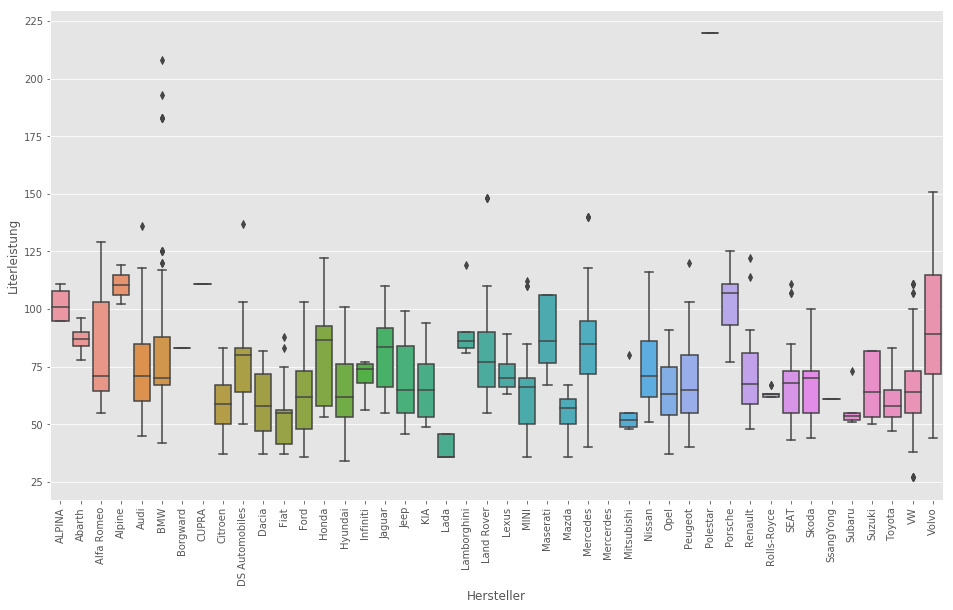

In [65]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(16,9))
    sns.boxplot(x="Hersteller", y="Literleistung", data=df, ax=ax)
    # sns.swarmplot(x="Hersteller", y="Literleistung", data=df_german.copy(), ax=ax, color=".25")
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

[Understanding Boxplot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)...

<div style="width:60%;"><img src="https://miro.medium.com/max/9000/1*2c21SkzJMf3frPXPAR_gZA.png"></div>

**Boxplot on a Normal Distribution**

<div style="width:60%;"><img src="https://miro.medium.com/max/8100/1*NRlqiZGQdsIyAu0KzP7LaQ.png"></div>

In [394]:
df[df.Hersteller == 'Alpine']

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
56,Alpine,A110,Otto,1798.0,185,Euro 6d-TEMP,2018-09-01,102
57,Alpine,A110S,Otto,1798.0,215,Euro 6d-TEMP-EVAP-ISC,2019-10-01,119


In [71]:
df[df.Motorart == 'Otto'].sort_values(by='Literleistung', ascending=False).head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
1561,Mercedes,CLA 45 AMG Shooting Brake (C117),Otto,1991,280,Euro 6d-TEMP,2018-06-01,140
1680,Mercedes,GLA 45 AMG,Otto,1991,280,Euro 6d-TEMP,2018-07-01,140
1560,Mercedes,CLA 45 AMG Coupé (C117),Otto,1991,280,Euro 6d-TEMP,2018-06-01,140
18,Alfa Romeo,Giulia Quadrifoglio,Otto,2891,375,Euro 6d-TEMP,2018-09-01,129
19,Alfa Romeo,Giulia Quadrifoglio,Otto,2891,375,Euro 6d-TEMP-EVAP-ISC,2019-07-01,129


In [72]:
df[df.Motorart == 'Diesel'].sort_values(by='Literleistung', ascending=False).head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
480,BMW,M550d Touring,Diesel,2993,294,Euro 6d-TEMP-EVAP,2018-07-01,98
602,BMW,X7 M50d,Diesel,2993,294,Euro 6d-TEMP-EVAP,2018-12-01,98
479,BMW,M550d,Diesel,2993,294,Euro 6d-TEMP-EVAP-ISC,2019-07-01,98
481,BMW,M550d Touring,Diesel,2993,294,Euro 6d-TEMP-EVAP-ISC,2019-07-01,98
505,BMW,750d,Diesel,2993,294,Euro 6d-TEMP-EVAP-ISC,2019-03-01,98


In [73]:
df.sort_values(by='Literleistung', ascending=False).head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung
2093,Polestar,1,Hybrid,2000,441,Euro 6d-TEMP,2019-10-01,220
292,BMW,i3s (94 Ah) (inkl. Range Extender),Elektro,647,135,Euro 6d-TEMP,2018-04-01,208
291,BMW,i3 (94 Ah) (inkl. Range Extender),Elektro,647,125,Euro 6d-TEMP,2018-04-01,193
528,BMW,i8 Roadster,Hybrid,1499,275,Euro 6d-TEMP-EVAP-ISC,2019-07-01,183
527,BMW,i8 Roadster,Hybrid,1499,275,Euro 6d-TEMP-EVAP,2018-05-01,183


In [396]:
from numpy import log
df.Hubraum.apply(lambda x : log(x))

0       7.221105
1       7.221105
2       7.221105
3       7.221105
4       7.221105
          ...   
2869    7.584773
2870    6.906755
2871    6.906755
2872    6.906755
2873    6.906755
Name: Hubraum, Length: 2874, dtype: float64

# Statistical plots

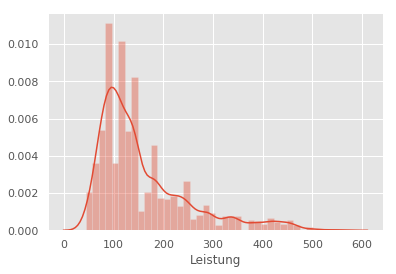

In [412]:
with plt.style.context('ggplot'):
    sns.distplot(df.Leistung)

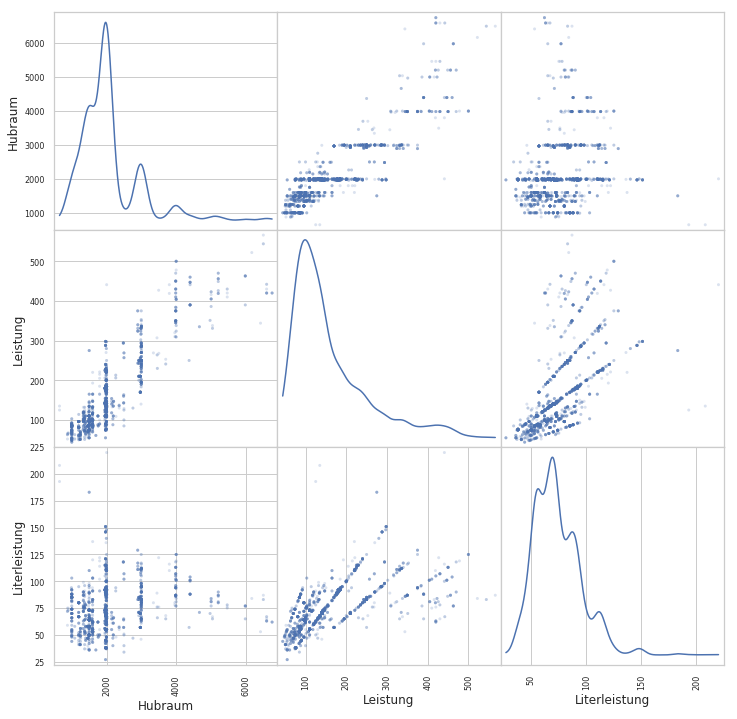

In [450]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde');

# Join

In [86]:
%pip install html5lib

     |████████████████████████████████| 122kB 508kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [90]:
df_ov = pd.read_html("https://en.wikipedia.org/wiki/List_of_manufacturers_by_motor_vehicle_production", header=0)

In [99]:
pd.concat(df_ov, sort=False).Group.dropna().unique()

array(['Toyota', 'Volkswagen Group', 'Hyundai / Kia',
       'General Motors (with SAIC-GM-Wuling)[d]', 'Ford', 'Nissan',
       'Honda', 'FCA', 'Renault', 'Groupe PSA', 'Suzuki', 'SAIC',
       'Daimler', 'BMW', 'Geely', 'Changan', 'Mazda', 'Dongfeng Motor',
       'BAIC', 'Mitsubishi', 'Great Wall', 'Fiat Chrysler',
       'PSA Peugeot Citroën', 'Dongfeng', 'Tata', 'General Motors',
       'Chrysler', 'Fiat', 'Hyundai / Kia[c]', 'AvtoVAZ', 'FAW Group[e]',
       'Subaru', 'Toyota (with Daihatsu and Hino)[a]', 'Daihatsu',
       'Nissan[f][26]', 'DaimlerChrysler', 'Nissan[f]', 'Dongfeng[g]',
       'BAIC[h]', 'General Motors (with GM Daewoo)[i]', 'GM Daewoo'],
      dtype=object)

In [100]:
aze = pd.concat(df_ov, sort=False)

In [108]:
aze['Group'] = aze.Group.str.replace('\[\w+\]', '')

In [113]:
aze.columns

Index(['Rank', 'Group', 'Country', 'Vehicles', 'Total', 'Cars', 'LCV', 'HCV',
       'Buses', 'Total motor vehicle production',
       ...
       'Total motor vehicle production.115',
       'Total motor vehicle production.116',
       'Total motor vehicle production.117',
       'Total motor vehicle production.118',
       'Total motor vehicle production.119', 'Unnamed: 120',
       'vteAutomotive industry', 'vteAutomotive industry.1', 'Africa',
       'Egypt Ethiopia Ghana Ivory Coast Libya Kenya Morocco Namibia Nigeria South Africa Sudan Tunisia'],
      dtype='object', length=134)

In [137]:
countries = aze[["Group", "Country"]].dropna(axis=0, how='any').drop_duplicates(subset='Group')

In [162]:
countries.rename({"Group": "Hersteller"}, axis=1, inplace=True)

In [164]:
df.columns

Index(['Hersteller', 'Modell', 'Motorart', 'Hubraum', 'Leistung', 'Abgasnorm',
       'Markteinfuehrung', 'Literleistung'],
      dtype='object')

In [182]:
countries

,Hersteller,Country
0,Toyota,Japan
1,Volkswagen Group,Germany
2,Hyundai / Kia,South Korea
3,General Motors (with SAIC-GM-Wuling),United States (China)
4,Ford,United States
...,...,...
1,Toyota (with Daihatsu and Hino),Japan
16,Daihatsu,Japan
4,DaimlerChrysler,Germany / United States
0,General Motors (with GM Daewoo),United States


In [178]:
df_merged = pd.merge(df, countries, how='left')

In [181]:
df_merged[df_merged.Country == "Germany"]

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung,Literleistung,Country
291,BMW,i3 (94 Ah) (inkl. Range Extender),Elektro,647,125,Euro 6d-TEMP,2018-04-01,193,Germany
292,BMW,i3s (94 Ah) (inkl. Range Extender),Elektro,647,135,Euro 6d-TEMP,2018-04-01,208,Germany
293,BMW,116i (F20/F21),Otto,1499,80,Euro 6d-TEMP-EVAP,2018-07-01,53,Germany
294,BMW,118d (F20/F21),Diesel,1995,110,Euro 6d-TEMP-EVAP,2018-03-01,55,Germany
295,BMW,118i (F20/F21),Otto,1499,100,Euro 6d-TEMP-EVAP,2018-07-01,66,Germany
...,...,...,...,...,...,...,...,...,...
610,BMW,Z4 Roadster M40i,Otto,1998,250,Euro 6d-TEMP-EVAP-ISC,2019-07-01,125,Germany
611,BMW,Z4 Roadster sDrive20i,Otto,1998,145,Euro 6d-TEMP-EVAP,2019-03-01,72,Germany
612,BMW,Z4 Roadster sDrive20i,Otto,1998,145,Euro 6d-TEMP-EVAP-ISC,2019-07-01,72,Germany
613,BMW,Z4 Roadster sDrive30i,Otto,1998,190,Euro 6d-TEMP-EVAP,2019-03-01,95,Germany


In [167]:
df.join(countries, on='Hersteller', how="left")

ValueError: columns overlap but no suffix specified: Index(['Hersteller'], dtype='object')

# Pivot

In [421]:
df.pivot_table(values="Leistung", index="Hersteller", columns="Hubraum", aggfunc="max")

Hubraum,647.0,875.0,898.0,988.0,998.0,999.0,1084.0,1193.0,1194.0,1197.0,...,5000.0,5038.0,5204.0,5461.0,5980.0,6166.0,6417.0,6498.0,6592.0,6749.0
Hersteller,,,,,,,,,,,,,,,,,,,,,
ALPINA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abarth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alfa Romeo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alpine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Audi,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,...,NaN,NaN,456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BMW,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,NaN
Borgward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUPRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Citroen,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [434]:
df['bin'] = pd.cut(df.Hubraum, np.arange(550, 3100, 100))
pv = df.pivot_table(values="Leistung", index="Hersteller", columns="bin", aggfunc="max", dropna=True).describe()
pv

bin,"(550, 650]","(850, 950]","(950, 1050]","(1050, 1150]","(1150, 1250]","(1250, 1350]","(1350, 1450]","(1450, 1550]","(1550, 1650]","(1650, 1750]",...,"(1850, 1950]","(1950, 2050]","(2050, 2150]","(2150, 2250]","(2250, 2350]","(2350, 2450]","(2450, 2550]","(2750, 2850]","(2850, 2950]","(2950, 3050]"
count,1.0,3.000000,19.000000,1.0,11.000000,7.000000,10.000000,21.000000,21.000000,3.000000,...,1.0,32.000000,2.000000,7.000000,2.000000,3.000000,7.000000,1.0,4.000000,11.000000
mean,135.0,66.666667,78.947368,63.0,79.181818,111.714286,107.200000,118.000000,109.952381,93.666667,...,225.0,199.968750,150.500000,130.142857,161.000000,134.666667,183.857143,130.0,324.000000,293.454545
std,NaN,1.154701,15.167486,NaN,18.835170,17.736162,13.926793,43.119601,39.608681,28.290163,...,NaN,68.490868,4.949747,19.316906,73.539105,4.163332,68.742099,NaN,52.858301,55.923812
min,135.0,66.000000,52.000000,63.0,59.000000,75.000000,88.000000,75.000000,75.000000,61.000000,...,225.0,110.000000,147.000000,103.000000,109.000000,130.000000,125.000000,130.0,250.000000,184.000000
25%,135.0,66.000000,74.000000,63.0,63.500000,110.500000,103.000000,96.000000,85.000000,85.500000,...,225.0,147.000000,148.750000,118.000000,135.000000,133.000000,136.000000,130.0,310.750000,253.500000
50%,135.0,66.000000,85.000000,63.0,70.000000,117.000000,106.500000,110.000000,88.000000,110.000000,...,225.0,199.500000,150.500000,135.000000,161.000000,136.000000,163.000000,130.0,335.500000,294.000000
75%,135.0,67.000000,88.000000,63.0,96.000000,118.500000,110.000000,121.000000,130.000000,110.000000,...,225.0,222.000000,152.250000,145.000000,187.000000,137.000000,216.500000,130.0,348.750000,336.000000
max,135.0,68.000000,103.000000,63.0,114.000000,132.000000,132.000000,275.000000,220.000000,110.000000,...,225.0,441.000000,154.000000,147.000000,213.000000,138.000000,294.000000,130.0,375.000000,375.000000


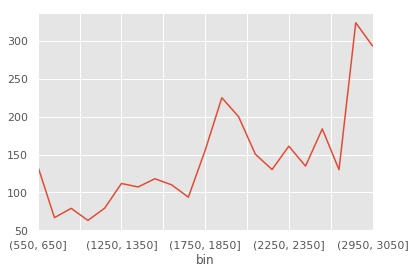

In [445]:
with plt.style.context('ggplot'):
    pv.T['mean'].plot()

# Ploting

In [270]:
pd.set_option('plotting.backend', 'altair')

In [271]:
import altair as alt

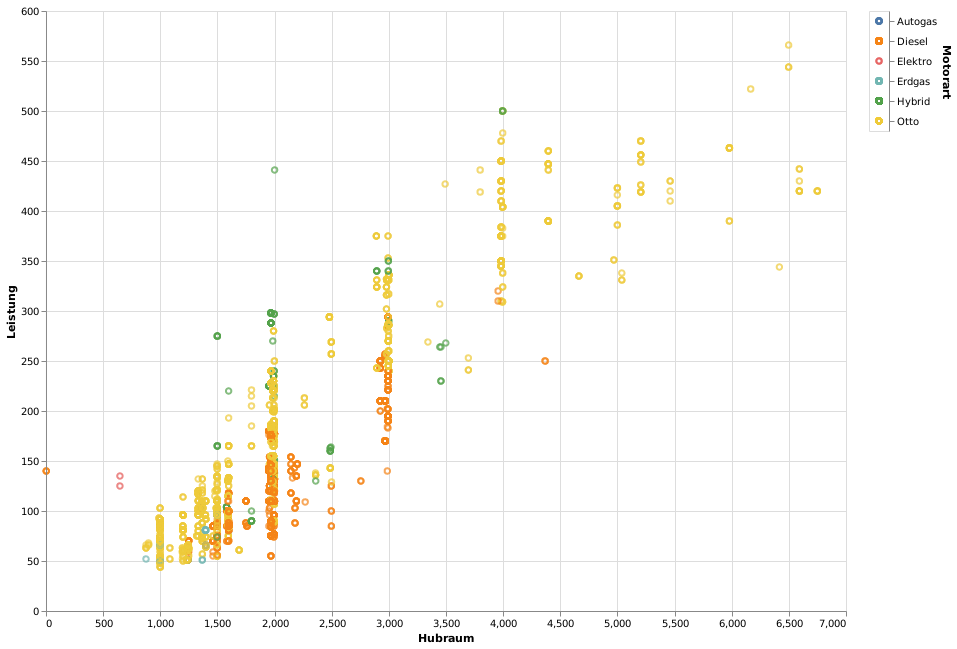

In [272]:
selection = alt.selection_multi(fields=['Motorart'])
color = alt.condition(selection,
                      alt.Color('Motorart:N', legend=None),
                      alt.value('lightgray'))

scatter = alt.Chart(df).mark_point().encode(
    x='Hubraum:Q',
    y='Leistung:Q',
    color=color,
    tooltip='Modell:N'
)

legend = alt.Chart(df).mark_point().encode(
    y=alt.Y('Motorart:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

g = scatter | legend

g.configure_view(
    height=600,
    width=800
)

# Groupby operation

In [273]:
g = df.groupby(['Hersteller', 'Hubraum'], sort=True)

In [274]:
dfg = g.aggregate({'Leistung': ['min', 'max']}).dropna()
dfg

Leistung       
                        min    max
Hersteller Hubraum                
ALPINA     2979.0     324.0  332.0
           2993.0     285.0  285.0
           4395.0     447.0  447.0
Abarth     1368.0     107.0  132.0
Alfa Romeo 1368.0      88.0   88.0
...                     ...    ...
VW         2995.0     250.0  250.0
           3956.0     310.0  310.0
Volvo      1477.0     115.0  120.0
           1498.0      90.0  112.0
           1969.0      88.0  298.0

[265 rows x 2 columns]

In [275]:
dfg.loc[('Volvo')]

Leistung       
             min    max
Hubraum                
1477.0     115.0  120.0
1498.0      90.0  112.0
1969.0      88.0  298.0

In [40]:
dfg.loc[('Volvo')].Leistung

,min,max
Hubraum,,
1477,115.0,120.0
1498,90.0,112.0
1969,88.0,298.0


In [41]:
dfg.sample()

Leistung       
                        min    max
Hersteller Hubraum                
Alpine     1798       185.0  215.0

In [18]:
def plot(df):
    selection = alt.selection_multi(fields=['Motorart'])
    color = alt.condition(selection,
                          alt.Color('Motorart:N', legend=None),
                          alt.value('lightgray'))

    scatter = alt.Chart(df).mark_point().encode(
        x='Hubraum:Q',
        y='Leistung:Q',
        color=color,
        tooltip='Modell:N'
    )

    legend = alt.Chart(df).mark_point().encode(
        y=alt.Y('Motorart:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )

    g = scatter | legend

    g.configure_view(
        height=600,
        width=800
    )
    
    return g

In [19]:
g.head(1).head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
0,Abarth,595,Otto,1368,107,Euro 6d-TEMP-EVAP,2018-09-01
8,Alfa Romeo,Giulia 2.0 Turbo 16V,Otto,1955,147,Euro 6d-TEMP,2018-09-01
12,Alfa Romeo,Giulia 2.2 Diesel,Diesel,2143,118,Euro 6d-TEMP-EVAP,2018-09-01
18,Alfa Romeo,Giulia Quadrifoglio,Otto,2891,375,Euro 6d-TEMP,2018-09-01
20,Alfa Romeo,Giulietta 1.4 TB 16V,Otto,1368,88,Euro 6d-TEMP,2018-11-01


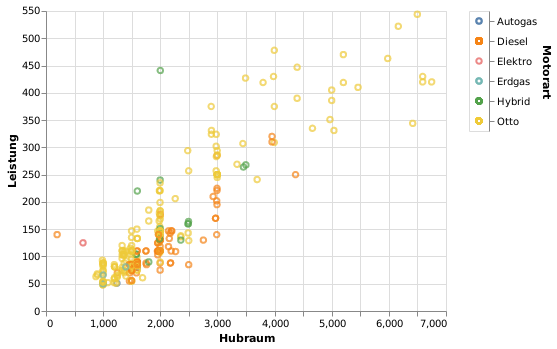

In [20]:
plot(g.head(1))

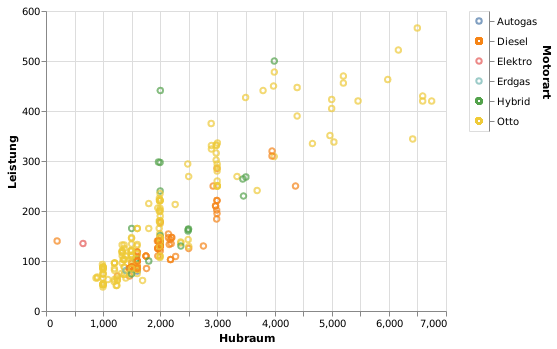

In [104]:
plot(g.tail(1))

In [ ]:
df.groupby('id').filter(lambda g: (g.nunique() > 1).any())

In [78]:
g.filter(lambda a: a.Leistung == a.Leistung.max())

TypeError: filter function returned a Series, but expected a scalar bool

In [65]:
g.groups

{('ALPINA', 2979): Int64Index([35, 36, 37, 38, 39, 40], dtype='int64'),
 ('ALPINA', 2993): Int64Index([45, 46, 47, 48, 52, 53, 54, 55], dtype='int64'),
 ('ALPINA', 4395): Int64Index([41, 42, 43, 44, 49, 50, 51], dtype='int64'),
 ('Abarth', 1368): Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64'),
 ('Alfa Romeo', 1368): Int64Index([20], dtype='int64'),
 ('Alfa Romeo', 1598): Int64Index([21], dtype='int64'),
 ('Alfa Romeo', 1955): Int64Index([8, 9, 10, 11], dtype='int64'),
 ('Alfa Romeo', 1956): Int64Index([22], dtype='int64'),
 ('Alfa Romeo', 1995): Int64Index([23, 24, 25, 26], dtype='int64'),
 ('Alfa Romeo',
  2143): Int64Index([12, 13, 14, 15, 16, 17, 27, 28, 29, 30, 31, 32], dtype='int64'),
 ('Alfa Romeo', 2891): Int64Index([18, 19, 33, 34], dtype='int64'),
 ('Alpine', 1798): Int64Index([56, 57], dtype='int64'),
 ('Audi', 999): Int64Index([58, 59, 71, 72, 89, 90, 222, 223], dtype='int64'),
 ('Audi',
  1498): Int64Index([60, 63, 64, 75, 76, 85, 86, 93, 94, 226, 233], dtype='int64'),

In [325]:
g.get_group(('ALPINA', 2979)).Leistung.max

<bound method Series.max of 35    324
36    324
37    324
38    332
39    324
40    332
Name: Leistung, dtype: int64>

In [41]:
df.groupby(['Abgasnorm', 'Hersteller']).size().sort_values()

ValueError: No axis named desc for object type <class 'pandas.core.series.Series'>

In [55]:
df.pivot_table(values='Hubraum in ccm', index='Abgasnorm', columns='Hersteller', aggfunc=len).dropna(axis=1)

Hersteller,ALPINA,Citroen,DSAutomobiles,Mercedes
Abgasnorm,,,,
Euro 6d,5.0,2.0,3.0,6.0
Euro 6d-TEMP,9.0,38.0,7.0,198.0


In [303]:
df.columns

Index(['Hersteller', 'Modell', 'Motorart', 'Hubraum', 'Leistung', 'Abgasnorm',
       'Markteinfuehrung', 'Literleistung'],
      dtype='object')

In [313]:
gp_lmplot = df.groupby(by=["Hersteller", 'Motorart', "Hubraum"])

In [324]:
gp_lmplot.agg(max)

Leistung  Literleistung Markteinfuehrung Modell
Hersteller Motorart Hubraum                                                  
ALPINA     Autogas  1.995          NaN            NaN              NaT    NaN
                    647.000        NaN            NaN              NaT    NaN
                    875.000        NaN            NaN              NaT    NaN
                    898.000        NaN            NaN              NaT    NaN
                    988.000        NaN            NaN              NaT    NaN
...                                ...            ...              ...    ...
Volvo      Otto     6166.000       NaN            NaN              NaT    NaN
                    6417.000       NaN            NaN              NaT    NaN
                    6498.000       NaN            NaN              NaT    NaN
                    6592.000       NaN            NaN              NaT    NaN
                    6749.000       NaN            NaN              NaT    NaN

[31416 rows x 4 columns]

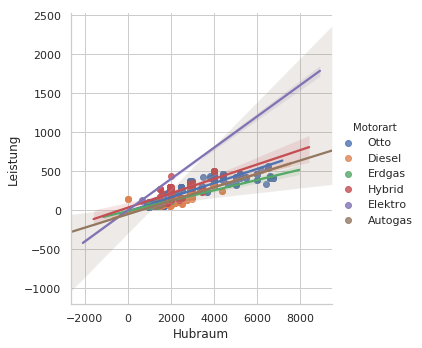

In [308]:
sns.lmplot(x="Hubraum", y="Leistung", hue="Motorart", data=df);

# Umweltdaten

In [42]:
from bs4 import BeautifulSoup

In [43]:
url = "https://www.adac.de/infotestrat/autodatenbank/autokatalog/baureihe.aspx?hersteller=VW"

# Getting the webpage, creating a Response object.
response = requests.get(url)

# Extracting the source code of the page.
data = response.text

# Passing the source code to BeautifulSoup to create a BeautifulSoup object for it.
soup = BeautifulSoup(data, 'lxml')

# Extracting all the <a> tags into a list.
tags = soup.find_all('a')

In [53]:
df.columns

Index(['Hersteller', 'Modell', 'Motorart', 'Hubraum', 'Leistung', 'Abgasnorm',
       'Markteinfuehrung'],
      dtype='object')

In [54]:
vw = df[df.Hersteller.str.lower() == "vw"]
# Rename columns as in base DataFrame for later join
vw = vw.rename({"Leistung in kW": "kW", "Hubraum in ccm": "ccm"}, axis=1)

In [55]:
vw.sample()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
2742,VW,Passat 1.6 TDI SCR,Diesel,1598,88,Euro 6d-TEMP-EVAP-ISC,Aug. 19


In [56]:
models = df.Modell.drop_duplicates()

In [57]:
models.str.split(expand=True)

,0,1,2,3,4,5,6
0,595,None,None,None,None,None,None
1,595,Pista,None,None,None,None,None
2,595,Turismo,None,None,None,None,None
3,595,Competizione,None,None,None,None,None
4,595C,None,None,None,None,None,None
...,...,...,...,...,...,...,...
2864,Touran,1.5,TSI,OPF,ACT,None,None
2866,Touran,2.0,TDI,SCR,None,None,None
2870,up!,1.0,None,None,None,None,None
2872,up!,1.0,TSI,None,None,None,None


In [58]:
res = pd.read_html("https://www.adac.de/infotestrat/autodatenbank/autokatalog/modelle.aspx?baureihe=T6%2bCalifornia&limit=10000")[0]

In [59]:
len(res)

168

In [60]:
res["C02"] = res["C02"].str.replace(" g/km", "")
res["C02"] = res["C02"].astype(int)

In [63]:
url = ("https://www.adac.de/infotestrat/autodatenbank/autokatalog/modelle.aspx?" +
       urlencode({"baureihe" : "+".join("T6 Caravelle 2.0 TDI".split())}))

In [64]:
vw.head()

,Hersteller,Modell,Motorart,Hubraum,Leistung,Abgasnorm,Markteinfuehrung
2615,VW,Arteon 1.5 TSI OPF,Otto,1498,110,Euro 6d-TEMP,Okt. 18
2616,VW,Arteon 2.0 TSI OPF,Otto,1984,140,Euro 6d-TEMP-EVAP,Mai 19
2617,VW,Arteon 2.0 TSI OPF,Otto,1984,140,Euro 6d-TEMP-EVAP-ISC,Jun. 19
2618,VW,Arteon 2.0 TSI OPF,Otto,1984,200,Euro 6d-TEMP-EVAP,Nov. 18
2619,VW,Arteon 2.0 TSI OPF,Otto,1984,200,Euro 6d-TEMP-EVAP-ISC,Jun. 19


## join data on ccm and kW

In [65]:
index = ['ccm', 'kW']

In [66]:
eng_char = res[["Kraftstoff", "kW", "C02", "ccm"]].drop_duplicates()

In [67]:
df_joined = vw.set_index(index).join(eng_char.set_index(index))

KeyError: "None of ['ccm', 'kW'] are in the columns"

In [31]:
df_joined.sample()

,,Hersteller,Modell,Motorart,Abgasnorm,Markt- einführung,Kraftstoff,C02
ccm,kW,,,,,,,
1968,84,VW,T6 Caravelle 2.0 TDI,Diesel,Euro 6d-TEMP,Nov. 18,Diesel,188.0


In [33]:
df_joined.reset_index().dropna()

,ccm,kW,Hersteller,Modell,Motorart,Abgasnorm,Markt- einführung,Kraftstoff,C02
55,1968,75,VW,Caddy 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,166.0
56,1968,75,VW,Caddy 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,193.0
57,1968,75,VW,Caddy 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,187.0
58,1968,75,VW,Caddy Beach 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,166.0
59,1968,75,VW,Caddy Beach 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,193.0
60,1968,75,VW,Caddy Beach 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,187.0
61,1968,75,VW,Caddy Alltrack 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,166.0
62,1968,75,VW,Caddy Alltrack 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,193.0
63,1968,75,VW,Caddy Alltrack 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,187.0
64,1968,75,VW,Caddy Kombi 2.0 TDI,Diesel,Euro 6d-TEMP,Okt. 18,Diesel,166.0


In [42]:
res = pd.read_html(url)

ImportError: html5lib not found, please install it

In [38]:
res[0]

,Vergleich,Vergleich.1,Bezeichnung,Aufbau,Türen,Kraftstoff,kW,C02,ccm,Listenpreis,Details
0,NaN,NaN,VW up! GTI,Schrägheck,3,Super,85,110 g/km,999,17300-,NaN
1,NaN,NaN,VW up! GTI,Schrägheck,5,Super,85,110 g/km,999,17780-,NaN


In [75]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:58.0) Gecko/20100101 Firefox/58.0'
}

r = requests.get("https://www.adac.de/infotestrat/autodatenbank/autokosten/suchergebnis.aspx", headers=headers)

In [78]:
r.request.headers

{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:58.0) Gecko/20100101 Firefox/58.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}

In [79]:
qsd = pd.read_html(r.content)

ValueError: No tables found